# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [15]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
#Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

### Dataset loading and preprocessing

In [16]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=50, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

In [36]:
data_matrix = df = pd.DataFrame()

data_matrix = pd.read_csv("Data_folder/Data.csv", header= None)

print(data_matrix)


# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self):
        x = data_matrix.iloc[0:, 3:].values
        y = data_matrix.iloc[0:, 0:2].values
        
        # Add normalization for x
        x = preprocessing.normalize(x)
        # print(x)

        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        
my_data_set = Droplet_data_set()

# Split the single dataset into 3 datasets for training, test and validation.
split = DataSplit(my_data_set, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=512, num_workers=0)

       0    1    2             3         4         5         6         7    \
0      2.3  0.2    1  1.507010e-26  0.012809  0.025618  0.038426  0.051234   
1      2.4  0.2    1 -1.908640e-26  0.012808  0.025616  0.038423  0.051230   
2      2.5  0.2    1  1.076793e-27  0.012807  0.025614  0.038421  0.051226   
3      2.6  0.2    1 -2.257969e-27  0.012806  0.025613  0.038418  0.051223   
4      2.7  0.2    1 -2.748220e-26  0.012806  0.025611  0.038416  0.051220   
...    ...  ...  ...           ...       ...       ...       ...       ...   
9939  43.5  1.8    1 -7.287111e-26  0.018726  0.037444  0.056150  0.074834   
9940  43.5  1.9    1 -4.066788e-25  0.019148  0.038288  0.057413  0.076516   
9941  43.5  2.0    1 -2.686497e-25  0.019565  0.039121  0.058662  0.078179   
9942  43.5  2.1    1 -2.609213e-25  0.019977  0.039945  0.059897  0.079822   
9943  43.5  2.2    1  2.115247e-25  0.020384  0.040759  0.061116  0.081445   

           8         9    ...       153       154       155    

### Deside to apply host or device

In [37]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Define the functions we need

In [38]:
def loss_cal_per_epoch(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch/t)

def train(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss_cal_per_epoch(loss_train, model, train_loader)
        loss_cal_per_epoch(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
    
    x = range(1, epochs+1)
    plt.plot(x, loss_train, 'b-', label="training loss")
    plt.plot(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score


### Train PhysicsNet

epoch 1: train_loss = 194.0393, val_loss = 352.1212
epoch 2: train_loss = 84.7947, val_loss = 150.9703
epoch 3: train_loss = 235.0306, val_loss = 419.1755
epoch 4: train_loss = 187.6998, val_loss = 334.4529
epoch 5: train_loss = 141.1249, val_loss = 248.2866
epoch 6: train_loss = 108.6596, val_loss = 193.4623
epoch 7: train_loss = 148.6560, val_loss = 266.2643
epoch 8: train_loss = 173.0999, val_loss = 309.4828
epoch 9: train_loss = 127.3154, val_loss = 229.8877
epoch 10: train_loss = 81.7652, val_loss = 143.5977
epoch 11: train_loss = 177.6104, val_loss = 312.5288
epoch 12: train_loss = 129.2201, val_loss = 230.1652
epoch 13: train_loss = 68.1700, val_loss = 121.9520
epoch 14: train_loss = 120.5781, val_loss = 214.9621
epoch 15: train_loss = 36.3714, val_loss = 63.9188
epoch 16: train_loss = 22.6060, val_loss = 38.8621
epoch 17: train_loss = 35.3783, val_loss = 65.6251
epoch 18: train_loss = 111.7871, val_loss = 200.6251
epoch 19: train_loss = 130.7040, val_loss = 234.6669
epoch 20: t

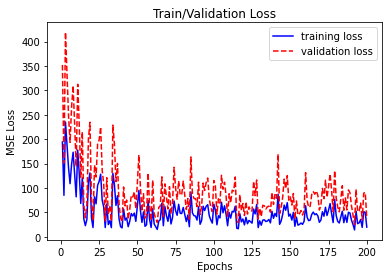

In [40]:
in_channel = 160
node_1 = 512
node_2 = 512
node_3 = 256
node_4 = 64
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 200

train(model_physics, optimizer, epoch)
PATH_CAL = os.path.join(os.getcwd(), "model_cal")
torch.save(model_physics, PATH_CAL)

### Visualization of outcomes

In [41]:
model_trained = torch.load(PATH_CAL)

examples = enumerate(test_loader)
_, (x_test_example, y_test_example) = next(examples)

score_example = prediction(model_trained, x_test_example)

# Print only 8 data samples for comparison
print("Ground Truths =", y_test_example[:8])
print("Prediction    =", score_example[:8, :])

Ground Truths = tensor([[25.0000,  2.1000],
        [32.8000,  0.3000],
        [13.7000,  2.5000],
        [21.4000,  2.0000],
        [35.7000,  0.6000],
        [33.1000,  1.3000],
        [35.6000,  1.4000],
        [28.3000,  1.2000]])
Prediction    = tensor([[22.4674,  2.0595],
        [29.2420,  0.4035],
        [13.5444,  2.6289],
        [19.8414,  1.9866],
        [39.6253,  0.6389],
        [35.4274,  1.3134],
        [35.0990,  1.3868],
        [34.8003,  1.2440]])
